# Artificial Neural Networks for Regression

_By: Ling Li Ya, Liana_

## Pre-training Preparation

### Installing Dependencies

In [1]:
!pip install tensorflow
!pip install keras

### Import Libraries

In [99]:
import pandas as pd
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler

### Loading Data

In [3]:
X_train_no = pd.read_csv('../dataset/no_outliers/X_train.csv')
X_test_no = pd.read_csv('../dataset/no_outliers/X_test.csv')
y_train_no = pd.read_csv('../dataset/no_outliers/y_train.csv')
y_test_no = pd.read_csv('../dataset/no_outliers/y_test.csv')

X_train_with = pd.read_csv('../dataset/with_outliers/X_train.csv')
X_test_with = pd.read_csv('../dataset/with_outliers/X_test.csv')
y_train_with = pd.read_csv('../dataset/with_outliers/y_train.csv')
y_test_with = pd.read_csv('../dataset/with_outliers/y_test.csv')

In [4]:
X_train_no.head()

,season,year,month,holiday,weekday,weather,temperature,humidity,windspeed
0,1,1,1,0,4,1,0.190000,0.497500,0.220158
1,2,1,5,0,6,1,0.564167,0.480417,0.123133
2,3,0,7,0,0,1,0.719167,0.604167,0.245033
3,3,0,8,0,2,1,0.639167,0.548333,0.125008
4,1,0,1,0,2,2,0.216667,0.861667,0.146775


In [5]:
print(X_train_no.shape, y_train_no.shape)

(578, 9) (578, 1)


## Training

Using a layer with 5 neurons, with 9 input dimensions of normal weight, using relu activation function. Batch size is 20 and training epochs are 50.

In [6]:
model = Sequential()

# Defining the input layer and first hidden layer
model.add(Dense(units=5, input_dim=9, kernel_initializer='normal', activation='relu'))

# Defining the second layer of the model
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node as only a single number is predicted
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the training data
model.fit(X_train_no[2:], y_train_no[2:], batch_size=20, epochs=50, verbose=1)

Epoch 1/50


2021-11-24 16:47:46.698638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 16:47:46.698741: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 16:47:46.698797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Liana-ASUS): /proc/driver/nvidia/version does not exist
2021-11-24 16:47:46.699281: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


29/29 [==============================] - 0s 1ms/step - loss: 23880196.0000
Epoch 2/50
29/29 [==============================] - 0s 966us/step - loss: 23879330.0000
Epoch 3/50
29/29 [==============================] - 0s 973us/step - loss: 23877210.0000
Epoch 4/50
29/29 [==============================] - 0s 808us/step - loss: 23873958.0000
Epoch 5/50
29/29 [==============================] - 0s 929us/step - loss: 23870884.0000
Epoch 6/50
29/29 [==============================] - 0s 831us/step - loss: 23868306.0000
Epoch 7/50
29/29 [==============================] - 0s 906us/step - loss: 23866058.0000
Epoch 8/50
29/29 [==============================] - 0s 990us/step - loss: 23863984.0000
Epoch 9/50
29/29 [==============================] - 0s 842us/step - loss: 23862022.0000
Epoch 10/50
29/29 [==============================] - 0s 773us/step - loss: 23860136.0000
Epoch 11/50
29/29 [==============================] - 0s 885us/step - loss: 23858284.0000
Epoch 12/50
29/29 [========================

## Hyperparameter Tuning

To find the best accuracy with the minimum number of layers/neurons.

### Grid Search

In [95]:
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]

    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    trial_number=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            trial_number += 1
            # create ANN model
            model = Sequential()

            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # Output neuron
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(trial_number, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100 - MAPE)
            
            SearchResultsData = SearchResultsData.append(pd.DataFrame(data=[[trial_number, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]], columns=['TrialNumber', 'Parameters', 'Accuracy_Series'] ))

    return(SearchResultsData)

ResultsData = FunctionFindBestParams(X_train_no, y_train_no, X_test_no, y_test_no)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: count    7.458453
dtype: float64
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: count    36.301583
dtype: float64
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: count    48.385843
dtype: float64
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: count    53.719543
dtype: float64
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: count    0.865084
dtype: float64
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: count    1.964378
dtype: float64
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: count    50.984979
dtype: float64
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: count    48.749069
dtype: float64
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: count    0.005952
dtype: float64
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: count    0.765753
dtype: float64
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: count    50.199679
dtype: float64
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: count   

### Plotting Results

In [96]:
# Taking only numerical data from the series for graph plotting
ResultsData['Accuracy'] = [x for a in range(ResultsData.shape[0]) for x in ResultsData['Accuracy_Series'].values[a]]
ResultsData = ResultsData.drop(labels=['Accuracy_Series'], axis=1)
ResultsData

,TrialNumber,Parameters,Accuracy
0,1,5-5,7.458453
0,2,5-10,36.301583
0,3,5-50,48.385843
0,4,5-100,53.719543
0,5,10-5,0.865084
0,6,10-10,1.964378
0,7,10-50,50.984979
0,8,10-100,48.749069
0,9,15-5,0.005952
0,10,15-10,0.765753


<AxesSubplot:xlabel='Parameters'>

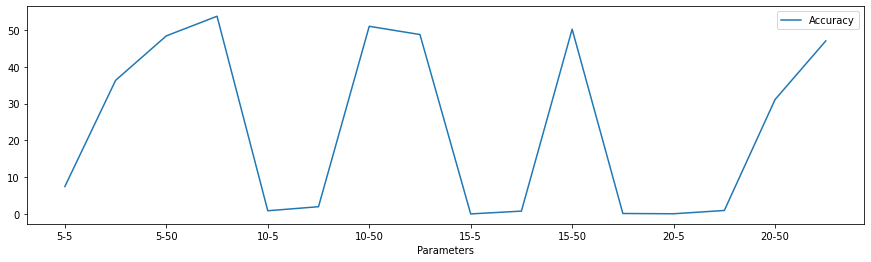

In [97]:
ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')



From the graph above, it can be known that the best hyperparameters are batch_size = 15 and epochs = 5.

In [102]:
# Fine-tine hyperparameters
model.fit(X_train_no, y_train_no, batch_size = 15, epochs = 5, verbose = 0)

pred = model.predict(X_test_no)

target_scaler = MinMaxScaler()

# Scale predictions
# pred = target_scaler.inverse_transform(pred)

# y_test_no = target_scaler.inverse_transform(y_test)

test_data = pd.DataFrame(data=X_test_no)
test_data['count'] = y_test_no
test_data['pred_count'] = pred
test_data.head()

,season,year,month,holiday,weekday,weather,temperature,humidity,windspeed,count,pred_count
0,3,1,7,0,0,1,0.721667,0.623750,0.170396,6597,13.166577
1,2,1,5,0,4,1,0.593333,0.520000,0.229475,7384,13.166584
2,3,1,8,0,5,2,0.765833,0.642500,0.215792,7175,13.166591
3,2,1,4,0,5,1,0.403333,0.377083,0.300388,6460,13.166582
4,4,1,11,0,1,1,0.319167,0.494167,0.236325,5259,13.166591


In [103]:
# Mean Absolute Percentage Error
APE = 100 * (abs(test_data['count'] - test_data['pred_count']) / test_data['count'])
test_data['APE'] = APE

print("Accuracy: ", 100 - np.mean(APE))
test_data.head()

Accuracy:  0.4031583723935057


,season,year,month,holiday,weekday,weather,temperature,humidity,windspeed,count,pred_count,APE
0,3,1,7,0,0,1,0.721667,0.623750,0.170396,6597,13.166577,99.800416
1,2,1,5,0,4,1,0.593333,0.520000,0.229475,7384,13.166584,99.821688
2,3,1,8,0,5,2,0.765833,0.642500,0.215792,7175,13.166591,99.816494
3,2,1,4,0,5,1,0.403333,0.377083,0.300388,6460,13.166582,99.796183
4,4,1,11,0,1,1,0.319167,0.494167,0.236325,5259,13.166591,99.749637
